In [1]:
import numpy as np
import pandas as pd
import scipy.optimize 
import pylab as plt
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
from scipy.signal import find_peaks
import librosa
import librosa.display
import matplotlib.patches as patches
import scipy
import latexify as lt
from scipy import signal

In [2]:
#Indoor: 2-5 Metronome
#outdoor: 2-8 Walk
#Outdoor: 11-13 talking

In [3]:
def fit_sin(tt,yy):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt),(tt[1]-tt[0]))
    ff = ff[:len(tt)//2]
    
    
    Fyy = np.abs(np.fft.fft(yy)[:len(tt)//2])
    guess_freq = np.abs(ff[np.argmax(Fyy[12:])+12])
    print("My calculated guess is = {}".format(guess_freq*60))
    guess_amp = np.std(yy)*2**0.5
    guess_offset=np.mean(yy)
    guess = np.array([guess_amp,2.*np.pi*guess_freq,0.,guess_offset])
    
    def sinfunc(t,A,w,p,c): return A*np.sin(w*t+p)+c
    popt, pcov = scipy.optimize.curve_fit(sinfunc,tt,yy,p0=guess)
    A,w,p,c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A*np.sin(w*t+p)+c
    return {"Amplitude":A, "Omega":w, "Phase":p, "Offset":c, "Freq":f, "Period":1./f, "FitFunc":fitfunc,"Maxcov":np.max(pcov),"Rawres":(guess,popt,pcov)}
    

In [4]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;



In [5]:
df = pd.read_csv("Data Collection/021_outdoor.csv",names=['Time','Data'])
df.index = pd.to_datetime(df['Time'])
df = df.drop(['Time'],axis=1)
#set the timestamp of events

duration = 60

timeStamps = [(i, i+duration) for i in range(0,840,duration)]

for startTime, endTime in timeStamps:
    try:
        metronome_data = df.iloc[startTime:endTime]
        tt = [i for i in range(0,metronome_data.shape[0])]
        signal = metronome_data.Data

        res = fit_sin(tt, signal)
        #print( "Amplitude=%(Amplitude)s, Freq.=%(Freq)s, phase=%(Phase)s, offset=%(Offset)s, Max. Cov.=%(Maxcov)s" % res )

        tt2 = np.linspace(0, metronome_data.shape[0], 100*metronome_data.shape[0])
        peaks,_ = find_peaks(res["FitFunc"](tt2))
        '''
        plt.plot(tt, signal, "b-", label="original Signal")
        plt.plot(tt2, res["FitFunc"](tt2), "r-", label="y fit curve", linewidth=2)
        plt.plot([tt2[peak] for peak in peaks], [res["FitFunc"](tt2)[i] for i in peaks], "x", color='black')
        plt.legend(loc="best")
        plt.show()
        '''

        print("For Start Time {} Minute and End Time {} Minute".format(startTime/60,endTime/60))
        print("Breathing Rate Via FFT = {:.2f}, Breathing Rate Via Peak Detect = {}".format(res['Freq']*60,len(peaks)))
        rr_peak_to_peak = np.max(tt2)/(np.mean(np.diff([tt2[peak] for peak in peaks])))
        print("Breathing Rate Via Peak to Peak Time = {:.2f}\n\n".format(rr_peak_to_peak))
    except:
        print("Could Not Find For {} minute to {} minute".format(startTime,endTime))


My calculated guess is = 20.0
For Start Time 0.0 Minute and End Time 1.0 Minute
Breathing Rate Via FFT = 19.83, Breathing Rate Via Peak Detect = 20
Breathing Rate Via Peak to Peak Time = 19.83


My calculated guess is = 20.0
For Start Time 1.0 Minute and End Time 2.0 Minute
Breathing Rate Via FFT = 19.78, Breathing Rate Via Peak Detect = 20
Breathing Rate Via Peak to Peak Time = 19.78


My calculated guess is = 20.0
For Start Time 2.0 Minute and End Time 3.0 Minute
Breathing Rate Via FFT = 20.10, Breathing Rate Via Peak Detect = 20
Breathing Rate Via Peak to Peak Time = 20.10


My calculated guess is = 20.0
For Start Time 3.0 Minute and End Time 4.0 Minute
Breathing Rate Via FFT = 19.79, Breathing Rate Via Peak Detect = 19
Breathing Rate Via Peak to Peak Time = 19.80


My calculated guess is = 20.0
For Start Time 4.0 Minute and End Time 5.0 Minute
Breathing Rate Via FFT = 19.87, Breathing Rate Via Peak Detect = 20
Breathing Rate Via Peak to Peak Time = 19.86


My calculated guess is = 

## Analysis of Signal During Ambulatory Mode
#### Unclean: 21_Outdoor_7-8 Mins
#### Clean: 26_Outdoor_4-5 Mins

My calculated guess is = 25.0
My calculated guess is = 24.0
For Start Time 7.0 Minute and End Time 8.0 Minute
Breathing Rate Via FFT = 23.84, Breathing Rate Via Peak Detect = 24
Breathing Rate Via Peak to Peak Time = 23.84



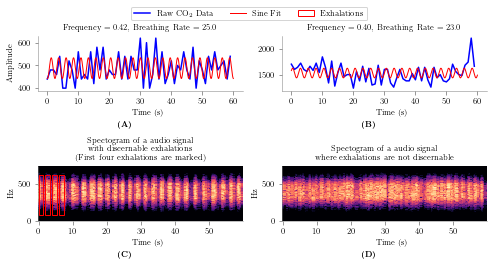

In [426]:
lt.latexify(columns=2, fig_height=3.5)

#load the first CO2 sample
df = pd.read_csv("Data Collection/026_outdoor.csv",names=['Time','Data'])
df.index = pd.to_datetime(df['Time'])
df = df.drop(['Time'],axis=1)

#load the corresponding audio sample
tidal, sr = librosa.load("Data Collection/026o16-18-36.wav", sr=1500) #026o16-18-36.wav #021o15-18-13.wav
startTime = 4*60
endTime = 5*60
tidal = tidal[sr*startTime:sr*endTime]
tidal_t = [s/sr for s in range(0,len(tidal))]

#choose the timestamp for CO2 Data
selected_data = df.iloc[startTime:endTime]

tt = [i for i in range(0,selected_data.shape[0])]

signal = selected_data.Data
res = fit_sin(tt, signal)
#print( "Amplitude=%(Amplitude)s, Freq.=%(Freq)s, phase=%(Phase)s, offset=%(Offset)s, Max. Cov.=%(Maxcov)s" % res )
tt2 = np.linspace(0, selected_data.shape[0], 1000*selected_data.shape[0])
peaks,_ = find_peaks(res["FitFunc"](tt2))

#normalised value of fit data
unnormalised_fit = res["FitFunc"](tt2)
normalised_fit = (2*(unnormalised_fit-np.min(unnormalised_fit))/(np.max(unnormalised_fit)-np.min(unnormalised_fit)))-1

#normalised value of the CO2 data
unnormalised_co2 = signal
normalised_co2 = (2*(unnormalised_co2-np.min(unnormalised_co2))/(np.max(unnormalised_co2)-np.min(unnormalised_co2)))-1




#start plotting
fig, ax  = plt.subplots(2,2)
ax[0,0].plot(tt, signal, "b-", label="Original CO$_2$ Signal")
ax[0,0].plot(tt2, res["FitFunc"](tt2), "r-", label="Sine Fit Curve", linewidth=1)
#ax[0].plot([tt2[peak] for peak in peaks], [res["FitFunc"](tt2)[i] for i in peaks], "x", color='black')
ax[0,0].set_xlabel(r"Time (s)\\\textbf{(A)}")
ax[0,0].set_ylabel("Amplitude")
ax[0,0].set_title("Frequency = {:.2f}, Breathing Rate = {}".format(res['Freq'],np.floor(res['Freq']*60)))
#ax[0,0].legend(loc='best', bbox_to_anchor=(0.4, 1.6, 0.5, 0.5),ncol=2)
#ax[0,0].set_ylim(400,2200)
lt.format_axes(ax[0,0])

#calculate fft and spectogram
tidal_f = butter_bandpass_filter(tidal,300,500,1500,5)
D = librosa.stft(tidal_f)  # STFT of y ######################
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
img = librosa.display.specshow(S_db,y_axis='linear',sr=fs,x_axis='s', ax=ax[1,0])
ax[1,0].set_title("Spectogram of a audio signal\n with discernable exhalations\n (First four exhalations are marked)")

#(x,y) width,height
rect1 = patches.Rectangle((0, 80), 1.4, 550, linewidth=1, edgecolor='r', facecolor='none')
ax[1,0].add_patch(rect1)
rect2 = patches.Rectangle((2, 80), 1.5, 550, linewidth=1, edgecolor='r', facecolor='none')
ax[1,0].add_patch(rect2)
rect3 = patches.Rectangle((4, 80), 1.5, 550, linewidth=1, edgecolor='r', facecolor='none')
ax[1,0].add_patch(rect3)
rect4 = patches.Rectangle((6, 80), 1.5, 550, linewidth=1, edgecolor='r', facecolor='none')
ax[1,0].add_patch(rect4)


#ax[1,0].plot(tidal_t, tidal)
#ax[1].plot(tt2-1,normalised_fit)
#ax[1].plot(tt,normalised_co2)
#ax[1,0].set_ylabel("Audio\nAmplitude")
ax[1,0].set_xlabel(r"Time (s)\\\textbf{(C)}")
lt.format_axes(ax[1,0])


#load the first CO2 sample
df = pd.read_csv("Data Collection/021_outdoor.csv",names=['Time','Data'])
df.index = pd.to_datetime(df['Time'])
df = df.drop(['Time'],axis=1)

#load the corresponding audio sample
tidal, sr = librosa.load("Data Collection/021o15-18-13.wav", sr=1500) #026o16-18-36.wav #021o15-18-13.wav
startTime = 7*60
endTime = 8*60
tidal = tidal[sr*startTime:sr*endTime]
tidal_t = [s/sr for s in range(0,len(tidal))]


#choose the timestamp for CO2 Data
selected_data = df.iloc[startTime:endTime]
tt = [i for i in range(0,selected_data.shape[0])]



signal = selected_data.Data
res = fit_sin(tt, signal)
#print( "Amplitude=%(Amplitude)s, Freq.=%(Freq)s, phase=%(Phase)s, offset=%(Offset)s, Max. Cov.=%(Maxcov)s" % res )
tt2 = np.linspace(0, selected_data.shape[0], 1000*selected_data.shape[0])
peaks,_ = find_peaks(res["FitFunc"](tt2))

#normalised value of fit data
unnormalised_fit = res["FitFunc"](tt2)
normalised_fit = (2*(unnormalised_fit-np.min(unnormalised_fit))/(np.max(unnormalised_fit)-np.min(unnormalised_fit)))-1

#normalised value of the CO2 data
unnormalised_co2 = signal
normalised_co2 = (2*(unnormalised_co2-np.min(unnormalised_co2))/(np.max(unnormalised_co2)-np.min(unnormalised_co2)))-1


ax[0,1].plot(tt, signal, "b-",label='_nolegend_')
ax[0,1].plot(tt2, res["FitFunc"](tt2), "r-", linewidth=1,label='_nolegend_')
#ax[0].plot([tt2[peak] for peak in peaks], [res["FitFunc"](tt2)[i] for i in peaks], "x", color='black')
ax[0,1].set_xlabel(r"Time (s)\\\textbf{(B)}")
ax[0,1].set_title("Frequency = {:.2f}, Breathing Rate = {}".format(res['Freq'],np.floor(res['Freq']*60)))
#ax[0,1].set_ylabel("Amplitude")
#ax[0,1].legend(loc='best', bbox_to_anchor=(0.5, 1.2, 0.5, 0.5),ncol=2)
#ax[0,1].set_ylim(400,2200)
lt.format_axes(ax[0,1])

#calculate fft and spectogram
tidal_f = butter_bandpass_filter(tidal,300,500,1500,5)
D = librosa.stft(tidal_f)  # STFT of y ######################
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
img = librosa.display.specshow(S_db,y_axis='linear',sr=1500,x_axis='s', ax=ax[1,1])
ax[1,1].set_title("Spectogram of a audio signal\n where exhalations are not discernable")

#ax[1,1].plot(tidal_t, tidal)
#ax[1].plot(tt2-1,normalised_fit)
#ax[1].plot(tt,normalised_co2)
#ax[1,1].set_ylabel("Audio\nAmplitude")
ax[1,1].set_xlabel(r"Time (s)\\\textbf{(D)}")
lt.format_axes(ax[1,1])
fig.legend(['Raw CO$_2$ Data','Sine Fit','Exhalations'],ncol=3,bbox_to_anchor=(0.5, 0.5, 0.25, 0.55))

fig.tight_layout()


plt.savefig('plots/ambulatory.pdf', bbox_inches='tight')
#calculate vitals
print("For Start Time {} Minute and End Time {} Minute".format(startTime/60,endTime/60))
print("Breathing Rate Via FFT = {:.2f}, Breathing Rate Via Peak Detect = {}".format(res['Freq']*60,len(peaks)))
rr_peak_to_peak = np.max(tt2)/(np.mean(np.diff([tt2[peak] for peak in peaks])))
print("Breathing Rate Via Peak to Peak Time = {:.2f}\n".format(rr_peak_to_peak))

In [210]:
len(tidal_f)

90000

In [165]:
labels

(['Original Signal', 'Sine Fit Curve'], [])

## Analysis of Metronome Quality
#### 028_Indoor_2_3_Mins

My calculated guess is = 13.0
For Start Time 2.0 Minute and End Time 3.0 Minute
Breathing Rate Via FFT = 13.07, Breathing Rate Via Peak Detect = 13
Breathing Rate Via Peak to Peak Time = 13.07



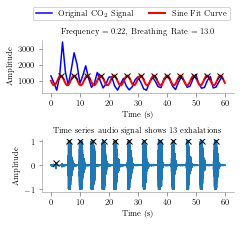

In [197]:
#load the CO2 sample
lt.latexify(fig_height=3.5)
df = pd.read_csv("Data Collection/028_indoor.csv",names=['Time','Data'])
df.index = pd.to_datetime(df['Time'])
df = df.drop(['Time'],axis=1)

startTime = 2*60
endTime = 3*60

#choose the timestamp for CO2 Data
selected_data = df.iloc[startTime:endTime]
tt = [i for i in range(0,selected_data.shape[0])]
signal = selected_data.Data
res = fit_sin(tt, signal)
#print( "Amplitude=%(Amplitude)s, Freq.=%(Freq)s, phase=%(Phase)s, offset=%(Offset)s, Max. Cov.=%(Maxcov)s" % res )
tt2 = np.linspace(0, selected_data.shape[0], 1000*selected_data.shape[0])
peaks_co2,_ = find_peaks(res["FitFunc"](tt2))

#normalised value of fit data
unnormalised_fit = res["FitFunc"](tt2)
normalised_fit = (2*(unnormalised_fit-np.min(unnormalised_fit))/(np.max(unnormalised_fit)-np.min(unnormalised_fit)))-1

#normalised value of the CO2 data
unnormalised_co2 = signal
normalised_co2 = (2*(unnormalised_co2-np.min(unnormalised_co2))/(np.max(unnormalised_co2)-np.min(unnormalised_co2)))-1

#calculate vitals
print("For Start Time {} Minute and End Time {} Minute".format(startTime/60,endTime/60))
print("Breathing Rate Via FFT = {:.2f}, Breathing Rate Via Peak Detect = {}".format(res['Freq']*60,len(peaks_co2)))
rr_peak_to_peak = np.max(tt2)/(np.mean(np.diff([tt2[peak] for peak in peaks_co2])))
print("Breathing Rate Via Peak to Peak Time = {:.2f}\n".format(rr_peak_to_peak))


#load the corresponding audio sample
tidal, sr = librosa.load("Data Collection/028i16-47-19.wav", sr=1500)
cutoff_low = 50
cutoff_high = 100
order = 5
fs = sr
downsampling_fs = 1000
respiration_rate = 0
tidal = tidal[sr*startTime:sr*endTime]
tidal_t = [s/fs for s in range(0,len(tidal))]
tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,fs,order)
#normalizing the waveform
#print(max(abs(tidal_f.max()),abs(tidal_f.min())))
tidal_f = tidal_f/max(abs(tidal_f.max()),abs(tidal_f.min()))

#apply hilbert transform
x_filt_hilbert = scipy.signal.hilbert(tidal)
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = fs /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 8.0 # stop band attenuation
fL_hz = 10
N, beta = scipy.signal.kaiserord(ripple_db, width)
taps = scipy.signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = scipy.signal.filtfilt(taps, 1,envelope_hat)
#peaks,_ = find_peaks(envelope_hat_filt,prominence = 0.04,distance= 2000,height = 0.15)
peaks,_ = find_peaks(tidal,distance= 5500)
if(len(peaks) > 1):
    #if the number of peaks in a recording are more than 1 (else consider respiration rate(rr) = 0)
    peak_to_peak = (tidal_t[peaks[len(peaks)-1]]-tidal_t[peaks[0]])/(len(peaks)-1) # average difference between the first and last peak 
    respiration_rate = max(tidal_t)/peak_to_peak # (total time interval till last peak) / (average difference between the first and last peak)


    
#calculate fft and spectogram
freqs,mags = compute_fft(tidal,fs) ########
D = librosa.stft(tidal_f,n_fft = 1024,win_length = 512)  # STFT of y ######################
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    
    
#start plotting
fig, ax  = plt.subplots(2,1)
ax[0].plot(tt, signal, "b-", label="Original CO$_2$ Signal")
ax[0].plot(tt2, res["FitFunc"](tt2), "r-", label="Sine Fit Curve", linewidth=2)
ax[0].plot([tt2[peak] for peak in peaks_co2], [res["FitFunc"](tt2)[i] for i in peaks_co2], "x", color='black')
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Frequency = {:.2f}, Breathing Rate = {}".format(res['Freq'],np.floor(res['Freq']*60)))
ax[0].legend(loc='best', bbox_to_anchor=(0.5, 1.2, 0.5, 0.5),ncol=2)
lt.format_axes(ax[0])

ax[1].plot(tidal_t, tidal)
#ax[1].plot(tidal_t,envelope_hat_filt,'r');
#ax[1].plot([tidal_t[peak] for peak in peaks], [envelope_hat_filt[i] for i in peaks], "x", color='black')
ax[1].plot([tidal_t[peak] for peak in peaks], [tidal[i] for i in peaks], "x", color='black')
#ax[1].plot(tt2-1,normalised_fit)
#ax[1].plot(tt,normalised_co2)
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Time series audio signal shows 13 exhalations")
lt.format_axes(ax[1])

#img = librosa.display.specshow(S_db,y_axis='linear',sr=fs,x_axis='time', ax=ax[2])
#lt.format_axes(ax[2])

fig.tight_layout()
plt.savefig('plots/wrong-metronome.pdf', bbox_inches='tight')



In [131]:
np.floor(2.3)

2.0

## Analysis of Forced Breathing
#### 028_Indoor_2_3_Mins

My calculated guess is = 14.0
For Start Time 10.0 Minute and End Time 11.0 Minute
Breathing Rate Via FFT = 13.90, Breathing Rate Via Peak Detect = 13
Breathing Rate Via Peak to Peak Time = 13.90



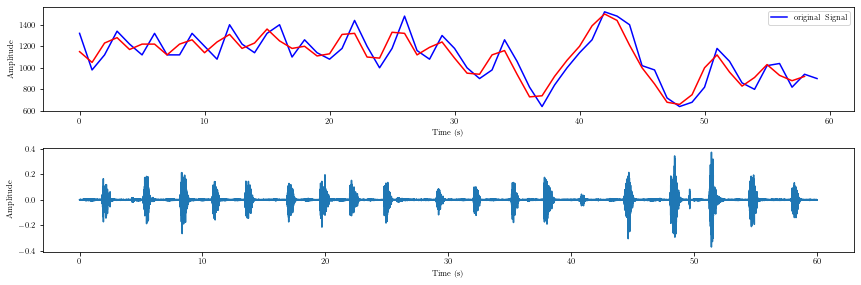

In [86]:
#load the CO2 sample
df = pd.read_csv("Data Collection/020_indoor.csv",names=['Time','Data'])
df.index = pd.to_datetime(df['Time'],format="%M:%S.%f")
df = df.drop(['Time'],axis=1)

#load the corresponding audio sample
tidal, sr = librosa.load("Data Collection/026i15-08-22.wav", sr=1500)
startTime = 10*60
endTime = 11*60
tidal = tidal[sr*startTime:sr*endTime]
tidal_t = [s/sr for s in range(0,len(tidal))]


#choose the timestamp for CO2 Data
selected_data = df.iloc[startTime:endTime]
tt = [i for i in range(0,selected_data.shape[0])]



signal = selected_data.Data
res = fit_sin(tt, signal)
#print( "Amplitude=%(Amplitude)s, Freq.=%(Freq)s, phase=%(Phase)s, offset=%(Offset)s, Max. Cov.=%(Maxcov)s" % res )
tt2 = np.linspace(0, selected_data.shape[0], 1000*selected_data.shape[0])
peaks,_ = find_peaks(res["FitFunc"](tt2))

#normalised value of fit data
unnormalised_fit = res["FitFunc"](tt2)
normalised_fit = (2*(unnormalised_fit-np.min(unnormalised_fit))/(np.max(unnormalised_fit)-np.min(unnormalised_fit)))-1

#normalised value of the CO2 data
unnormalised_co2 = signal
normalised_co2 = (2*(unnormalised_co2-np.min(unnormalised_co2))/(np.max(unnormalised_co2)-np.min(unnormalised_co2)))-1



filter_window_size = 2
signal_filtered = np.convolve(signal , np.ones((filter_window_size,))/filter_window_size, mode='valid')
t_ = tt[:-filter_window_size+1]


#start plotting
fig, ax  = plt.subplots(2,1, figsize=(12,4))
ax[0].plot(tt, signal, "b-", label="original Signal")
ax[0].plot(t_,signal_filtered,"r-")
#ax[0].plot(tt2, res["FitFunc"](tt2), "r-", label="y fit curve", linewidth=2)
#ax[0].plot([tt2[peak] for peak in peaks], [res["FitFunc"](tt2)[i] for i in peaks], "x", color='black')
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].legend(loc="best")

ax[1].plot(tidal_t, tidal)
#ax[1].plot(tt2-1,normalised_fit)
#ax[1].plot(tt,normalised_co2)
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Time (s)")

fig.tight_layout()

#calculate vitals
print("For Start Time {} Minute and End Time {} Minute".format(startTime/60,endTime/60))
print("Breathing Rate Via FFT = {:.2f}, Breathing Rate Via Peak Detect = {}".format(res['Freq']*60,len(peaks)))
rr_peak_to_peak = np.max(tt2)/(np.mean(np.diff([tt2[peak] for peak in peaks])))
print("Breathing Rate Via Peak to Peak Time = {:.2f}\n".format(rr_peak_to_peak))

My calculated guess is = 25.86206896551724
For Start Time 0.0 Minute and End Time 1.0 Minute
Breathing Rate Via FFT = 26.11, Breathing Rate Via Peak Detect = 25
Breathing Rate Via Peak to Peak Time = 25.24



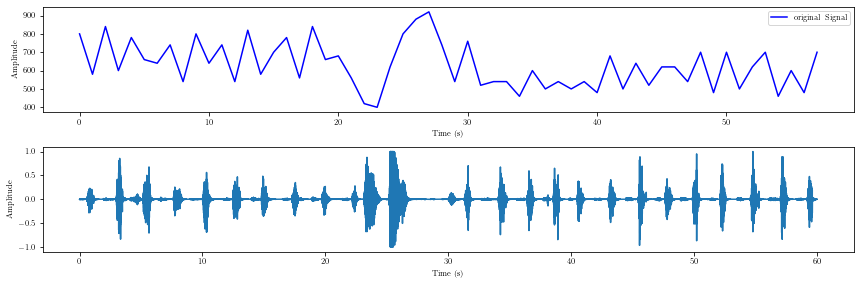

In [34]:
#load the CO2 sample
df = pd.read_csv("Data Collection/3.csv",names=['Time','Data'])
df.index = pd.to_datetime(df['Time'],format="%M:%S.%f")
df = df.drop(['Time'],axis=1)

#load the corresponding audio sample
tidal, sr = librosa.load("Data Collection/Audio2.wav", sr=1500)
startTime = 0
endTime = 60
tidal = tidal[sr*startTime:sr*endTime]
tidal_t = [s/sr for s in range(0,len(tidal))]


#choose the timestamp for CO2 Data
selected_data = df.iloc[startTime+2:endTime]
tt = [i for i in range(0,selected_data.shape[0])]



signal = selected_data.Data
res = fit_sin(tt, signal)
#print( "Amplitude=%(Amplitude)s, Freq.=%(Freq)s, phase=%(Phase)s, offset=%(Offset)s, Max. Cov.=%(Maxcov)s" % res )
tt2 = np.linspace(0, selected_data.shape[0], 1000*selected_data.shape[0])
peaks,_ = find_peaks(res["FitFunc"](tt2))

#normalised value of fit data
unnormalised_fit = res["FitFunc"](tt2)
normalised_fit = (2*(unnormalised_fit-np.min(unnormalised_fit))/(np.max(unnormalised_fit)-np.min(unnormalised_fit)))-1

#normalised value of the CO2 data
unnormalised_co2 = signal
normalised_co2 = (2*(unnormalised_co2-np.min(unnormalised_co2))/(np.max(unnormalised_co2)-np.min(unnormalised_co2)))-1



#filter_window_size = 2
#signal_filtered = np.convolve(signal , np.ones((filter_window_size,))/filter_window_size, mode='valid')
#t_ = tt[:-filter_window_size+1]


#start plotting
fig, ax  = plt.subplots(2,1, figsize=(12,4))
ax[0].plot(tt, signal, "b-", label="original Signal")
#ax[0].plot(t_,signal_filtered,"r-")
#ax[0].plot(tt2, res["FitFunc"](tt2), "r-", label="y fit curve", linewidth=2)
#ax[0].plot([tt2[peak] for peak in peaks], [res["FitFunc"](tt2)[i] for i in peaks], "x", color='black')
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].legend(loc="best")

ax[1].plot(tidal_t, tidal)
#ax[1].plot(tt2-1,normalised_fit)
#ax[1].plot(tt,normalised_co2)
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Time (s)")

fig.tight_layout()

#calculate vitals
print("For Start Time {} Minute and End Time {} Minute".format(startTime/60,endTime/60))
print("Breathing Rate Via FFT = {:.2f}, Breathing Rate Via Peak Detect = {}".format(res['Freq']*60,len(peaks)))
rr_peak_to_peak = np.max(tt2)/(np.mean(np.diff([tt2[peak] for peak in peaks])))
print("Breathing Rate Via Peak to Peak Time = {:.2f}\n".format(rr_peak_to_peak))

### BrPM vs Time
##### 1-2: Sitting
##### 2-8: Walking
##### 8-11: Sitting
##### Sample: Abhas (22)


In [312]:
df = pd.read_csv("Data Collection/021_outdoor.csv", names=['Time','Data'])
df.index = pd.to_datetime(df['Time'])
df = df.drop(['Time'],axis=1)
sr = 1 #as per sensor specification
selectedData = df.iloc[]

#set the timestamp of events
timeStamps = [(i, i+60) for i in range(0,660,60)]

plotID = 0
BrPMList = []
co2avg = []

for startTime, endTime in timeStamps:
    freqToSkip = 4
    data = np.array(df.iloc[startTime:endTime]).reshape(endTime-startTime)
    F,A = compute_fft(data, sr, n = None, scale_amplitudes = True)
    '''
    fig, ax = plt.subplots(2,1, figsize=(12,10))
    ax[0].plot(df.iloc[0:(endTime-startTime)])
    ax[0].set_title("Plot for Time {} - {} minute".format(startTime/60, endTime/60))
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('CO$_2$ (in ppm)')
    ax[0].set_ylim(400,8192)
    ax[1].plot(F[freqToSkip:],A[freqToSkip:])
    ax[1].set_title("Highest Freqeuncy Is = {:.2f} and BR = {}".format(F[np.argmax(A[freqToSkip:])+freqToSkip],F[np.argmax(A[freqToSkip:])+freqToSkip]*60))
    ax[1].set_ylabel('Amplitude')
    ax[1].set_xlabel('Frequency')
    '''
    BrPMList.append(F[np.argmax(A[freqToSkip:])+freqToSkip]*60)
    co2avg.append(np.mean(data))
    fig.tight_layout()


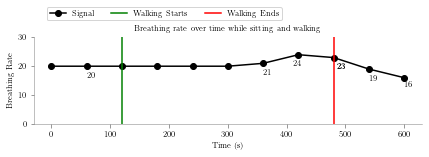

In [380]:
lt.latexify()
fig, ax = plt.subplots(1,1, figsize=(6,2.5))
#ax.plot([i*60 for i in range(0,len(BrPMList))],BrPMList)
ax.plot([i*60 for i in range(0,len(BrPMList))],BrPMList,'ok-')
#ax.plot([i*60 for i in range(0,len(BrPMList))],BrPMList-np.mean(BrPMList[:2]))
ax.axvline(60*2, color='green')
ax.axvline(60*8, color='red')
ax.text(60,16,'20')
ax.text(360,17,'21')
ax.text(410,20,'24')
ax.text(485,19,'23')
ax.text(485,19,'23')
ax.text(540,15,'19')
ax.text(600,13,'16')
ax.set_ylim(0,30)
ax.set_title("Breathing rate over time while sitting and walking")
ax.set_ylabel("Breathing Rate")
ax.set_xlabel("Time (s)")
ax.legend(['Signal','Walking Starts','Walking Ends'],loc="best",ncol=3, bbox_to_anchor=[0.40, 0.5,0.25,0.90])
lt.format_axes(ax)

fig.tight_layout()
plt.savefig('plots/brpm-time.pdf', bbox_inches='tight')
#ax.plot(np.diff(BrPMList))